In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import json
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [2]:
training_data_path = '../data/datasets/training_data_noisy_small_track_symetric_delayed_deviation.csv'
df = pd.read_csv(training_data_path)
print(f'{df.shape=}')
df.sample(5)

df.shape=(23760, 19)


,steering_angle,waypoint1_lat,waypoint1_lon,waypoint2_lat,waypoint2_lon,waypoint3_lat,waypoint3_lon,waypoint4_lat,waypoint4_lon,waypoint5_lat,waypoint5_lon,waypoint6_lat,waypoint6_lon,waypoint7_lat,waypoint7_lon,waypoint8_lat,waypoint8_lon,waypoint9_lat,waypoint9_lon
6992,-0.256013,-1.142151,4.398616,-0.494728,7.595085,-0.565402,9.866242,-2.005323,11.545876,-4.319967,12.497220,-7.069557,12.392177,-9.781639,11.640651,-11.904274,9.994740,-13.800426,7.543311
10334,-0.112371,4.181250,-3.149558,5.780550,-6.149784,7.379893,-9.150063,8.979305,-12.150440,10.630088,-15.283920,11.547440,-19.596923,9.683700,-23.796047,6.295472,-26.287191,2.641493,-27.414119
6336,-0.352279,-1.142132,4.398702,-0.461167,7.729785,0.026187,10.643269,-0.548107,12.590323,-2.470309,14.046857,-4.916072,14.578651,-7.820975,14.145487,-10.244211,13.133154,-12.280639,11.105303
21842,-0.345159,-2.731286,3.125855,-4.115913,6.634380,-2.488883,11.350623,0.212280,14.651757,4.074056,16.012318,7.379524,16.673807,9.815990,15.147426,15.764914,12.196070,16.295584,10.350458
5951,-0.129472,0.088524,-3.376565,-1.497635,-6.109289,-3.096949,-9.109564,-4.696278,-12.109882,-6.295612,-15.110227,-7.894965,-18.110575,-8.733212,-20.410282,-8.217673,-22.371472,-6.351933,-24.047476


In [3]:
X = df.drop(columns=['steering_angle'])
y = df['steering_angle']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((19008, 18), (4752, 18), (19008,), (4752,))

In [4]:
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization, Activation, Conv1D, Flatten, Dense, Reshape
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from datetime import datetime

model = Sequential([
    BatchNormalization(input_shape=(18,)),
    Reshape((9, 2)),  # reshape flat input to (9, 2)
    Conv1D(128, kernel_size=6, activation='relu'),
    Conv1D(64, kernel_size=3, activation='relu'),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(1)
])


timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
name = 'cnn_64_32_1_dense_64'
checkpoint = ModelCheckpoint(f'../weights/best_{name}_{timestamp}.h5', monitor='val_loss', save_best_only=True, mode='min')

model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 18)               72        
 ormalization)                                                   
                                                                 
 reshape (Reshape)           (None, 9, 2)              0         
                                                                 
 conv1d (Conv1D)             (None, 4, 128)            1664      
                                                                 
 conv1d_1 (Conv1D)           (None, 2, 64)             24640     
                                                                 
 flatten (Flatten)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                        

In [5]:
EPOCHS = 100
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=EPOCHS,
    batch_size=32,
    callbacks=[checkpoint],
    verbose=1
)

Epoch 1/100
594/594 [==============================] - 5s 4ms/step - loss: 0.0302 - mae: 0.1320 - val_loss: 0.0151 - val_mae: 0.0918
Epoch 2/100
594/594 [==============================] - 2s 4ms/step - loss: 0.0197 - mae: 0.1067 - val_loss: 0.0135 - val_mae: 0.0885
Epoch 3/100
594/594 [==============================] - 2s 4ms/step - loss: 0.0176 - mae: 0.1007 - val_loss: 0.0120 - val_mae: 0.0831
Epoch 4/100
594/594 [==============================] - 2s 4ms/step - loss: 0.0163 - mae: 0.0965 - val_loss: 0.0107 - val_mae: 0.0790
Epoch 5/100
594/594 [==============================] - 2s 4ms/step - loss: 0.0157 - mae: 0.0952 - val_loss: 0.0104 - val_mae: 0.0776
Epoch 6/100
594/594 [==============================] - 2s 4ms/step - loss: 0.0146 - mae: 0.0918 - val_loss: 0.0100 - val_mae: 0.0767
Epoch 7/100
594/594 [==============================] - 2s 4ms/step - loss: 0.0143 - mae: 0.0908 - val_loss: 0.0098 - val_mae: 0.0759
Epoch 8/100
594/594 [==============================] - 2s 4ms/step - 

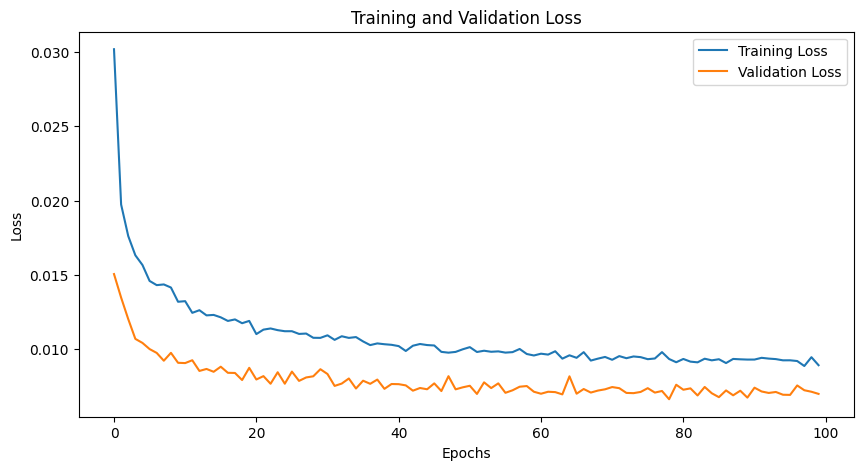

In [6]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

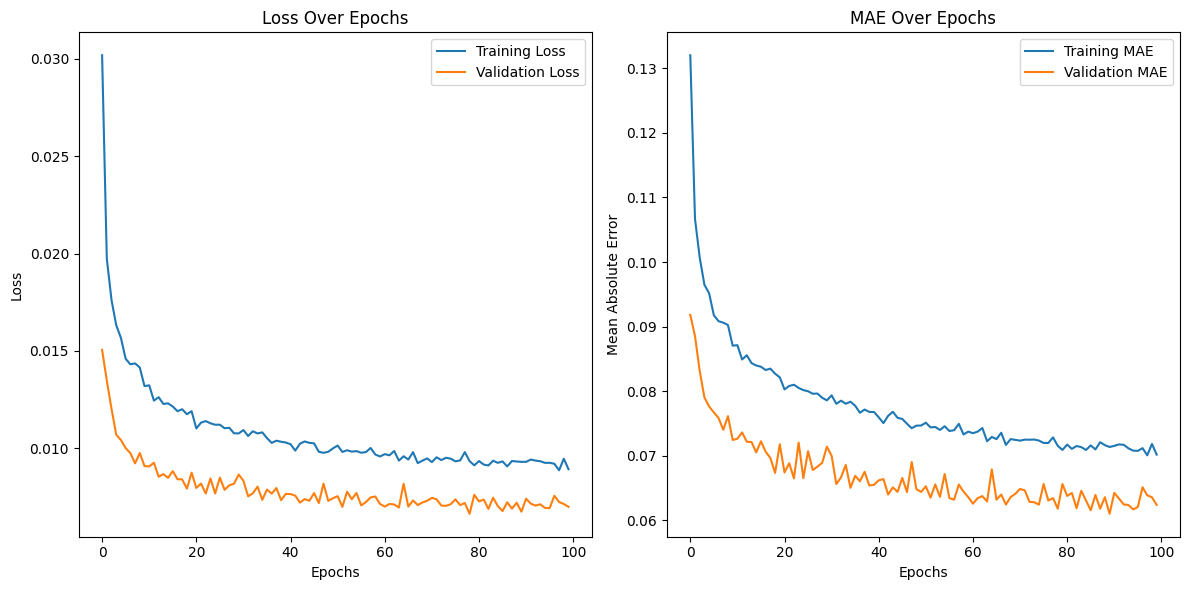

In [7]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Over Epochs')

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.title('MAE Over Epochs')

plt.tight_layout()
plt.show()

In [8]:
model.load_weights(checkpoint.filepath)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

metrics_df = pd.DataFrame({
    "Metric": ["Mean Squared Error (MSE)", "Mean Absolute Error (MAE)", "R-squared (R2)"],
    "Value": [mse, mae, r2]
})

metrics_df

149/149 [==============================] - 0s 2ms/step


,Metric,Value
0,Mean Squared Error (MSE),0.006638
1,Mean Absolute Error (MAE),0.061802
2,R-squared (R2),0.877307


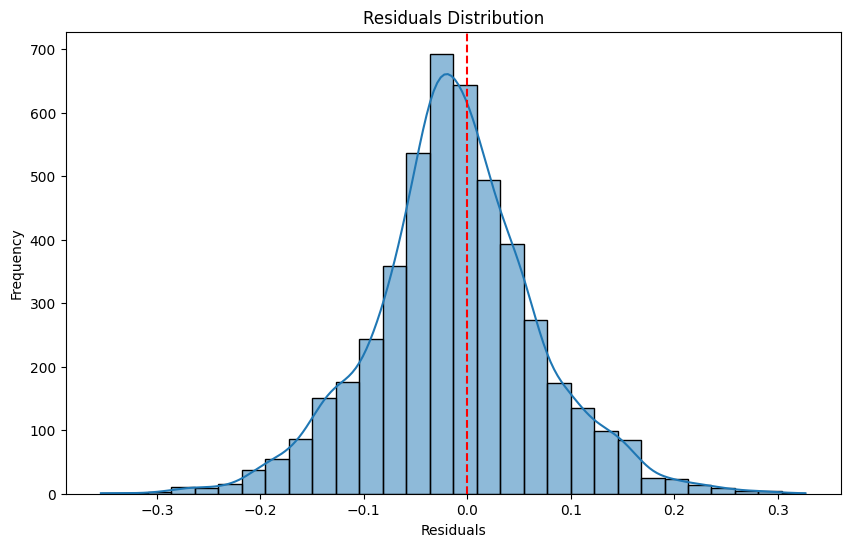

In [9]:
residuals = y_test - y_pred.flatten()
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True, bins=30)
plt.axvline(0, color='red', linestyle='--')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Residuals Distribution')
plt.show()

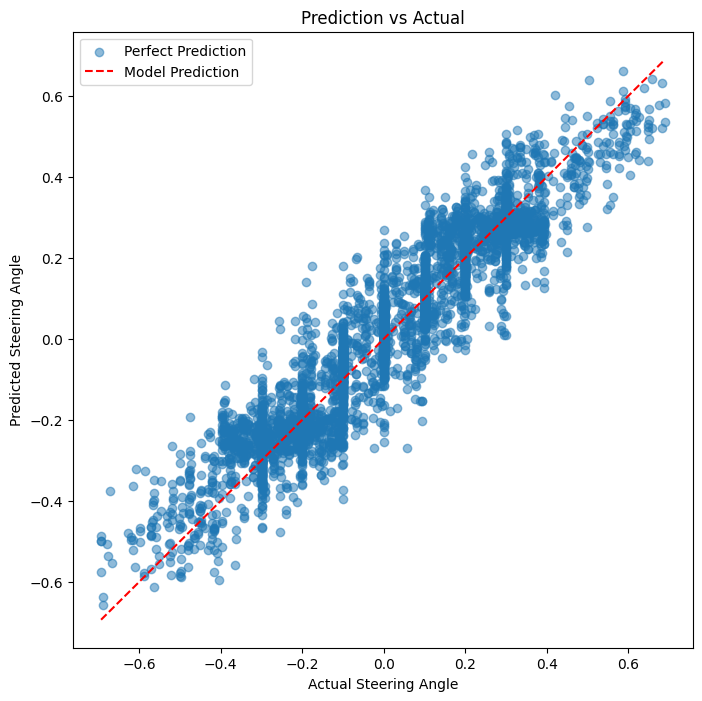

In [10]:
plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Steering Angle')
plt.ylabel('Predicted Steering Angle')
plt.title('Prediction vs Actual')
plt.legend(['Perfect Prediction', 'Model Prediction'])
plt.show()

In [11]:
model_json = model.to_json()
with open(f'../models/{name}.json', 'w') as json_file:
    json.dump(json.loads(model_json), json_file, indent=4)

In [12]:
metadata = {
    "model_name": name,
    "model_path": f"../models/{name}.json",
    "training_data_path": training_data_path,
    "timestamp": timestamp,
    "input_shape": list(X_train.shape[1:]),
    "output_shape": [1],
    "optimizer": {
        "type": "Adam",
        "learning_rate": 0.001
    },
    "loss_function": "mse",
    "metrics": ["mae"],
    "training": {
        "epochs": len(history.history['loss']),
        "batch_size": 32,
        "best_model_path": checkpoint.filepath,
        "final_training_loss": history.history['loss'][-1],
        "final_validation_loss": history.history['val_loss'][-1]
    },
    "evaluation": {
        "mse": mse,
        "mae": mae,
        "r2": r2
    }
}

try:
    with open("metadata.jsonl", "r+") as f:
        lines = f.readlines()
        entry = json.dumps(metadata) + "\n"
        if entry not in lines:
            f.write(entry)
except FileNotFoundError:
    with open("metadata.jsonl", "w") as f:
        f.write(json.dumps(metadata) + "\n")

In [13]:
with open("metadata.jsonl", "r") as f:
    lines = f.readlines()

print(json.dumps(json.loads(lines[-1]), indent=4))

{
    "model_name": "cnn_64_32_1_dense_64",
    "model_path": "../models/cnn_64_32_1_dense_64.json",
    "training_data_path": "../data/datasets/training_data_noisy_small_track_symetric_delayed_deviation.csv",
    "timestamp": "20250603_162031",
    "input_shape": [
        18
    ],
    "output_shape": [
        1
    ],
    "optimizer": {
        "type": "Adam",
        "learning_rate": 0.001
    },
    "loss_function": "mse",
    "metrics": [
        "mae"
    ],
    "training": {
        "epochs": 100,
        "batch_size": 32,
        "best_model_path": "../weights/best_cnn_64_32_1_dense_64_20250603_162031.h5",
        "final_training_loss": 0.008927024900913239,
        "final_validation_loss": 0.006996990647166967
    },
    "evaluation": {
        "mse": 0.006638260089957892,
        "mae": 0.06180174765736217,
        "r2": 0.8773071301678775
    }
}
